In [1]:
from matplotlib import pyplot as plt
import os, json, re, random, io, pytz, itertools, shutil
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
from pprint import pprint
from PIL import Image
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset

In [2]:
SIZES = [8, 9, 10]
OFFSETS = [-1, 0, 1]
COLORS = {
    "red": "#ff0000", 
    "blue": "#0000ff", 
    "green": "#008000",
    "black": "#000000",
    "pink": "#ff69b4", 
    "yellow": "#ffff00",
    "purple": "#800080",
    "orange": "#FFA500",
    "cyan": "#00FFFF",
    #"brown": "#A52A2A",
    "khaki": "#BDB76B",
    "grey": "#808080",
    "lime":"#00FF00",
}
RELATIONS = ["{0} is on top of {1}.", "{1} is at the bottom of {0}."]

In [3]:
dir = "../data/matplotlib/colored_2sq"

In [28]:
im_count = 0
layout_count = 0
pairs = []
annotations = {
      "metadata": {
            "relations": RELATIONS,
            "colors": COLORS,
            "sizes": SIZES,
            "offsets": OFFSETS,
      }
}
os.system(f"rm -rf {dir}/images/*")
for c1, c2 in itertools.product(COLORS, COLORS):
      if c1 == c2: continue
      for r1, r2, o1, o2 in tqdm(itertools.product(SIZES, SIZES, OFFSETS, OFFSETS), total=len(SIZES)**2*len(OFFSETS)**2):
            plt.ioff() # disable plt.show()
            fig = plt.figure(dpi=8, figsize=(4,4)) # The resulting resolution will be 128x128
            W, H = fig.get_size_inches()*fig.dpi
            fig.patches.append(Rectangle((0.5 - (r1+o1)/2.0/W, 0.5), r1/W, r1/H, facecolor=COLORS[c1], transform=fig.transFigure)) 
            fig.patches.append(Rectangle((0.5 - (r2+o2)/2.0/W, 0.5 - r2/H), r2/W, r2/H, facecolor=COLORS[c2], transform=fig.transFigure))
            plt.axis('off')
            imgid = str(im_count+10000000)[1:]
            fig.savefig(f"{dir}/images/{imgid}.png", format='png')
            plt.close(fig)

            sentences = []
            for i, r in enumerate(RELATIONS):
                  sentences.append({
                        "imgid": imgid,
                        "raw": r.format(f"a {c1} square", f"a {c2} square"),
                        "sentid": f"{imgid}{i}"
                  })
            pairs.append({
                  "imgid": imgid,
                  "filename": f"{imgid}.png",
                  "layout": RELATIONS[0].format(c1, c2),
                  "layoutid": str(layout_count+1000)[1:],
                  "sentences": sentences,
            })
            im_count += 1
      layout_count += 1
      #break
annotations['data'] = pairs
json.dump(annotations, open(f"{dir}/annotations.json", "w"), indent=2)


100%|██████████| 81/81 [00:00<00:00, 114.90it/s]


In [14]:
# Trial: figure rendering
fig = plt.figure(dpi=8, figsize=(4,4)) # The resulting resolution will be 128x128
W, H = fig.get_size_inches()*fig.dpi
r1, r2 = 8, 8
o1, o2 = 0, 0
fig.patches.append(Rectangle((0.5 - (r1+o1)/2.0/W, 0.5 - r1/H), r1/W, r1/H, facecolor=COLORS["lime"], transform=fig.transFigure))
fig.patches.append(Rectangle((0.5 - (r2+o2)/2.0/W, 0.5), r2/W, r2/H, facecolor=COLORS["pink"], transform=fig.transFigure)) 
plt.axis('off')
imgid = str(im_count+10000000)[1:]
plt.show()

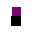

In [4]:
# Take a look at generated images
filename = random.choice(os.listdir(f"{dir}/images"))
im = Image.open(f"{dir}/images/{filename}").convert("RGB")
im

In [5]:
# Split dataset
# Criterion: for the same layout, one description is put in training and the other is put in testing
train = pd.DataFrame(columns=["sentid", "filename", "sentence"])
train.set_index("sentid")
test = pd.DataFrame(columns=["sentid", "filename", "sentence"])
test.set_index("sentid")
pairs = json.load(open(f"{dir}/annotations.json", "r"))["data"]
print(len(pairs))
pprint(pairs[0])

for d in pairs:
    train_sentence = int(d['layoutid']) % 2
    row = {
        "sentid": [d['sentences'][train_sentence]['sentid']],
        "filename": [d['filename']],
        "sentence": [d['sentences'][train_sentence]['raw']]
    }
    row = pd.DataFrame(row)
    train = pd.concat([train, pd.DataFrame(row)])
    test_sentence = 1 - train_sentence
    row = {
        "sentid": [d['sentences'][test_sentence]['sentid']],
        "filename": [d['filename']],
        "sentence": [d['sentences'][test_sentence]['raw']]
    }
    test = pd.concat([test, pd.DataFrame(row)])
print(len(train), len(test))

train.to_csv(f"{dir}/split1/train.csv", index=False)
test.to_csv(f"{dir}/split1/test.csv", index=False)


10692
{'filename': '0000000.png',
 'imgid': '0000000',
 'layout': 'red is on top of blue.',
 'layoutid': '000',
 'sentences': [{'imgid': '0000000',
                'raw': 'a red square is on top of a blue square.',
                'sentid': '00000000'},
               {'imgid': '0000000',
                'raw': 'a blue square is at the bottom of a red square.',
                'sentid': '00000001'}]}
10692 10692


In [33]:
#train.reset_index(drop=True)
train.head()

,sentid,filename,sentence
0,00000000,0000000.png,a red square is on top of a blue square.
0,00000010,0000001.png,a red square is on top of a blue square.
0,00000020,0000002.png,a red square is on top of a blue square.
0,00000030,0000003.png,a red square is on top of a blue square.
0,00000040,0000004.png,a red square is on top of a blue square.


In [35]:
# Take a look at the data split
data = load_dataset(f"{dir}/split1", split="test")
print(len(data))
pprint(data[1942])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
# Split dataset
# Criterion: for the same layout, both descriptions are put in training and
#           its opposite layout (with both descriptions) will be put in testing
train = pd.DataFrame(columns=["sentid", "filename", "sentence"])
train.set_index("sentid")
test = pd.DataFrame(columns=["sentid", "filename", "sentence"])
test.set_index("sentid")
pairs = json.load(open(f"{dir}/annotations.json", "r"))["data"]
print(len(pairs))
pprint(pairs[0])

train_pairs, test_pairs = [], []

for d in pairs:
    current_pair = tuple([w for w in d['layout'].strip()[:-1].split() if w in COLORS])
    if current_pair[::-1] in train_pairs:
        test_pairs.append(current_pair)
        for s in d['sentences']:
            row = {
                "sentid": [s['sentid']],
                "filename": [d['filename']],
                "sentence": [s['raw']]
            }
            test = pd.concat([test, pd.DataFrame(row)])
    else:
        train_pairs.append(current_pair)
        for s in d['sentences']:
            row = {
                "sentid": [s['sentid']],
                "filename": [d['filename']],
                "sentence": [s['raw']]
            }
            row = pd.DataFrame(row)
            train = pd.concat([train, pd.DataFrame(row)])
    
print(len(train), len(test))
train.to_csv(f"{dir}/split2/train.csv", index=False)
test.to_csv(f"{dir}/split2/test.csv", index=False)


10692
{'filename': '0000000.png',
 'imgid': '0000000',
 'layout': 'red is on top of blue.',
 'layoutid': '000',
 'sentences': [{'imgid': '0000000',
                'raw': 'a red square is on top of a blue square.',
                'sentid': '00000000'},
               {'imgid': '0000000',
                'raw': 'a blue square is at the bottom of a red square.',
                'sentid': '00000001'}]}
10692 10692


In [9]:
pprint(set(train_pairs))
print("-------------------------------------")
pprint(set(test_pairs))

{('black', 'cyan'),
 ('black', 'grey'),
 ('black', 'khaki'),
 ('black', 'lime'),
 ('black', 'orange'),
 ('black', 'pink'),
 ('black', 'purple'),
 ('black', 'yellow'),
 ('blue', 'black'),
 ('blue', 'cyan'),
 ('blue', 'green'),
 ('blue', 'grey'),
 ('blue', 'khaki'),
 ('blue', 'lime'),
 ('blue', 'orange'),
 ('blue', 'pink'),
 ('blue', 'purple'),
 ('blue', 'yellow'),
 ('cyan', 'grey'),
 ('cyan', 'khaki'),
 ('cyan', 'lime'),
 ('green', 'black'),
 ('green', 'cyan'),
 ('green', 'grey'),
 ('green', 'khaki'),
 ('green', 'lime'),
 ('green', 'orange'),
 ('green', 'pink'),
 ('green', 'purple'),
 ('green', 'yellow'),
 ('grey', 'lime'),
 ('khaki', 'grey'),
 ('khaki', 'lime'),
 ('orange', 'cyan'),
 ('orange', 'grey'),
 ('orange', 'khaki'),
 ('orange', 'lime'),
 ('pink', 'cyan'),
 ('pink', 'grey'),
 ('pink', 'khaki'),
 ('pink', 'lime'),
 ('pink', 'orange'),
 ('pink', 'purple'),
 ('pink', 'yellow'),
 ('purple', 'cyan'),
 ('purple', 'grey'),
 ('purple', 'khaki'),
 ('purple', 'lime'),
 ('purple', 'orange

In [10]:
# Take a look at the data split
data = load_dataset(f"{dir}/split2", split="test")
print(len(data))
pprint(data[1942])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

10692
{'filename': '0004616.png',
 'sentence': 'a yellow square is on top of a blue square.',
 'sentid': 46160}


In [5]:
# Split dataset
# Criterion: only "on top of" is seen. "at the bottom of" is never seen
train = pd.DataFrame(columns=["sentid", "filename", "sentence"])
train.set_index("sentid")
test = pd.DataFrame(columns=["sentid", "filename", "sentence"])
test.set_index("sentid")
pairs = json.load(open(f"{dir}/annotations.json", "r"))["data"]
print(len(pairs))
pprint(pairs[0])

for d in pairs:
    for s in d['sentences']:
        if 'top' in s['raw']:
            row = {
                "sentid": [s['sentid']],
                "filename": [d['filename']],
                "sentence": [s['raw']]
            }
            row = pd.DataFrame(row)
            train = pd.concat([train, pd.DataFrame(row)])
        else:
            row = {
                "sentid": [s['sentid']],
                "filename": [d['filename']],
                "sentence": [s['raw']]
            }
            test = pd.concat([test, pd.DataFrame(row)])
print(len(train), len(test))

train.to_csv(f"{dir}/impossible_split/train.csv", index=False)
test.to_csv(f"{dir}/impossible_split/test.csv", index=False)


10692
{'filename': '0000000.png',
 'imgid': '0000000',
 'layout': 'red is on top of blue.',
 'layoutid': '000',
 'sentences': [{'imgid': '0000000',
                'raw': 'a red square is on top of a blue square.',
                'sentid': '00000000'},
               {'imgid': '0000000',
                'raw': 'a blue square is at the bottom of a red square.',
                'sentid': '00000001'}]}
10692 10692


In [8]:
# Take a look at the data split
data = load_dataset(f"{dir}/impossible_split", split="test")
print(len(data))
pprint(data[1942])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

10692
{'filename': '0001942.png',
 'sentence': 'a blue square is at the bottom of a green square.',
 'sentid': 19421}


In [8]:
# Split dataset 
# Criterion: split3 --- similar to split2, but avoid inducing "position bias"
train = pd.DataFrame(columns=["sentid", "filename", "sentence"])
train.set_index("sentid")
test = pd.DataFrame(columns=["sentid", "filename", "sentence"])
test.set_index("sentid")
pairs = json.load(open(f"{dir}/annotations.json", "r"))["data"]
print(len(pairs))
pprint(pairs[0])

color2id = {k:i for i, k in enumerate(COLORS.keys())}

for d in pairs:
    c1, c2 = tuple([w for w in d['layout'].strip()[:-1].split() if w in COLORS])
    cid1, cid2 = color2id[c1], color2id[c2]
    if 1 <= cid1 - cid2 <= 5 or -11 <= cid1 - cid2 <= -6:
        for s in d['sentences']:
            row = {
                "sentid": [s['sentid']],
                "filename": [d['filename']],
                "sentence": [s['raw']]
            }
            row = pd.DataFrame(row)
            train = pd.concat([train, pd.DataFrame(row)])
    else:
        for s in d['sentences']:
            row = {
                "sentid": [s['sentid']],
                "filename": [d['filename']],
                "sentence": [s['raw']]
            }
            test = pd.concat([test, pd.DataFrame(row)])
print(len(train), len(test))

train.to_csv(f"{dir}/split3/train.csv", index=False)
test.to_csv(f"{dir}/split3/test.csv", index=False)


10692
{'filename': '0000000.png',
 'imgid': '0000000',
 'layout': 'red is on top of blue.',
 'layoutid': '000',
 'sentences': [{'imgid': '0000000',
                'raw': 'a red square is on top of a blue square.',
                'sentid': '00000000'},
               {'imgid': '0000000',
                'raw': 'a blue square is at the bottom of a red square.',
                'sentid': '00000001'}]}
10692 10692


In [15]:
# Take a look at the data split
data = load_dataset(f"{dir}/split3", split="test")
print(len(data))
pprint(data[4242])

10692
{'filename': '0004956.png',
 'sentence': 'a yellow square is on top of a orange square.',
 'sentid': 49560}


In [9]:
# Split dataset 
# Criterion: split4 --- two relations are learned with two disjoint sets of entities
#                   No identity-PoS bias
train = pd.DataFrame(columns=["sentid", "filename", "sentence"])
train.set_index("sentid")
test = pd.DataFrame(columns=["sentid", "filename", "sentence"])
test.set_index("sentid")
pairs = json.load(open(f"{dir}/annotations.json", "r"))["data"]
print(len(pairs))
pprint(pairs[0])

color2id = {k:i for i, k in enumerate(COLORS.keys())}

for d in pairs:
    c1, c2 = tuple([w for w in d['layout'].strip()[:-1].split() if w in COLORS])
    cid1, cid2 = color2id[c1], color2id[c2]
    if 0 <= cid1 <= 5 and 0 <= cid2 <= 5:
        train_sentence = 0
    elif 6 <= cid1 <= 11 and 6 <= cid2 <= 11:
        train_sentence = 1
    else: 
        for s in d['sentences']:
            row = {
                "sentid": [s['sentid']],
                "filename": [d['filename']],
                "sentence": [s['raw']]
            }
            test = pd.concat([test, pd.DataFrame(row)])
        continue
    row = {
        "sentid": [d['sentences'][train_sentence]['sentid']],
        "filename": [d['filename']],
        "sentence": [d['sentences'][train_sentence]['raw']]
    }
    row = pd.DataFrame(row)
    train = pd.concat([train, pd.DataFrame(row)])

    test_sentence = 1 - train_sentence
    row = {
        "sentid": [d['sentences'][test_sentence]['sentid']],
        "filename": [d['filename']],
        "sentence": [d['sentences'][test_sentence]['raw']]
    }
    test = pd.concat([test, pd.DataFrame(row)])
print(len(train), len(test))

train.to_csv(f"{dir}/split4/train.csv", index=False)
test.to_csv(f"{dir}/split4/test.csv", index=False)


10692
{'filename': '0000000.png',
 'imgid': '0000000',
 'layout': 'red is on top of blue.',
 'layoutid': '000',
 'sentences': [{'imgid': '0000000',
                'raw': 'a red square is on top of a blue square.',
                'sentid': '00000000'},
               {'imgid': '0000000',
                'raw': 'a blue square is at the bottom of a red square.',
                'sentid': '00000001'}]}
4860 16524


In [7]:
# Split dataset 
# Criterion: split5 --- Identity-Pos bias. 
#           e.g. Pp - Li are always seen as obj; Rd - Ye are always seen as subj.
train = pd.DataFrame(columns=["sentid", "filename", "sentence"])
train.set_index("sentid")
test = pd.DataFrame(columns=["sentid", "filename", "sentence"])
test.set_index("sentid")
pairs = json.load(open(f"{dir}/annotations.json", "r"))["data"]
print(len(pairs))
pprint(pairs[0])

color2id = {k:i for i, k in enumerate(COLORS.keys())}

for d in pairs:
    c1, c2 = tuple([w for w in d['layout'].strip()[:-1].split() if w in COLORS])
    cid1, cid2 = color2id[c1], color2id[c2]
    if 0 <= cid1 <= 5 and 6 <= cid2 <= 11:
        train_sentence = 0
    elif 6 <= cid1 <= 11 and 0 <= cid2 <= 5:
        train_sentence = 1
    else: 
        for s in d['sentences']:
            row = {
                "sentid": [s['sentid']],
                "filename": [d['filename']],
                "sentence": [s['raw']]
            }
            test = pd.concat([test, pd.DataFrame(row)])
        continue
    row = {
        "sentid": [d['sentences'][train_sentence]['sentid']],
        "filename": [d['filename']],
        "sentence": [d['sentences'][train_sentence]['raw']]
    }
    row = pd.DataFrame(row)
    train = pd.concat([train, pd.DataFrame(row)])

    test_sentence = 1 - train_sentence
    row = {
        "sentid": [d['sentences'][test_sentence]['sentid']],
        "filename": [d['filename']],
        "sentence": [d['sentences'][test_sentence]['raw']]
    }
    test = pd.concat([test, pd.DataFrame(row)])
print(len(train), len(test))

train.to_csv(f"{dir}/split5/train.csv", index=False)
test.to_csv(f"{dir}/split5/test.csv", index=False)


10692
{'filename': '0000000.png',
 'imgid': '0000000',
 'layout': 'red is on top of blue.',
 'layoutid': '000',
 'sentences': [{'imgid': '0000000',
                'raw': 'a red square is on top of a blue square.',
                'sentid': '00000000'},
               {'imgid': '0000000',
                'raw': 'a blue square is at the bottom of a red square.',
                'sentid': '00000001'}]}
5832 15552
